# Quantized MobileNetV2 for Pneumonia Detection with Google Coral Edge TPU and Transfer Learning.
Use TensorFlow 2 to create an image classification model, train it with the NIH Xray dataset, and convert it to TensorFlow Lite using post-training quantization. Afterwards, compile it for compatibility with the Edge TPU (available in [Coral devices](https://coral.ai/products/)).

The model is based on a pre-trained version of MobileNet V2. Training starts start by retraining only the classification layers, reusing MobileNet's pre-trained feature extractor layers. Afterwards, model is fine-tuned by updating weights in some of the feature extractor layers. This approach is a form of Transfer Learning, which is far faster than conventional Machine Learning and performs better on low-end devices.

Once model is trained, use post-training quantization to convert all parameters to int8 format, reducing the model size and increasing inferencing speed. This format is also required for compatibility on the Edge TPU.

## Import the required libraries 
In order to quantize both the input and output tensors, we need `TFLiteConverter` APIs that are available in TensorFlow r2.3 or higher. Scikit-learn is needed for splitting the dataset into training and testing batches. Matplotlib and Pandas are used to import, analyze, and plot the dataset. 

To install dependencies locally, run the following command

```
python3 -m pip install --user tensorflow numpy pandas matplotlib scikit-learn seaborn
```

Conda users are recommended to run
```
conda config --add channels conda-forge
conda config --set channel_priority strict
conda create -n tf_EdgeTPU jupyterlab ipympl tensorflow numpy pandas matplotlib scikit-learn seaborn
conda active tf_EdgeTPU && jupyter lab
```

And for MacOS users, install miniforge then run
```
conda create -n tf_EdgeTPU jupyterlab ipympl numpy pandas matplotlib scikit-learn seaborn
conda install -c apple tensorflow-deps
python -m pip install tensorflow-macos tensorflow-metal
conda active tf_EdgeTPU && jupyter lab
```

Run the following cell to load the necessary packages. Make sure to change the Accelerator on the right to `TPU` if you're running on Google Colab.

In [2]:
# general imports
import os
from datetime import datetime

# linalg and data/plots
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib widget

# ML
import tensorflow as tf
from sklearn.model_selection import train_test_split

## Device selection and GCS
If available, we want to use a TPU for training, as its far faster. We need a Google Cloud link to our data to load the data using a TPU. For CPU's and GPU's we leave this blank, as it is assumed the dataset is available locally. 

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Device:", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initializes_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    GCS_PATH = "gs://kds-730dfb73e90bcfe94bba623cbc90984df476fa507c3e44b785ea223e/"
except:
    print("Not connected to a TPU runtime")
    strategy = tf.distribute.get_strategy()
    GCS_PATH = ""

Not connected to a TPU runtime


## Preliminary Analysis of Pneumonia Deaths
Why are we targeting Pneumonia? While we have hopefully passed the height COVID-19 pandemic, those who where affected may face complications such as COVID-onset Pneumonia.

“As we have learned more about SARS-CoV-2 and resulting COVID-19, we have discovered that in severe COVID-19, a significant pro-inflammatory condition can result in several critical diseases, complications and syndromes,” -  Panagis Galiatsatos, M.D., M.H.S., expert on lung disease at Johns Hopkins Bayview Medical Center 

COVID-19 can cause lung complications such as pneumonia, causing lasting harm to the lungs and other organs. In pneumonia, the lungs become filled with fluid and inflamed, leading to breathing difficulties. For some people, breathing problems can become severe enough to require treatment at the hospital with oxygen or even a ventilator. The pneumonia that COVID-19 causes tends to take hold in both lungs. Air sacs in the lungs fill with fluid, limiting their ability to take in oxygen and causing shortness of breath, cough and other symptoms. While most people recover from pneumonia without any lasting lung damage, the pneumonia associated with COVID-19 can be severe. Even after the disease has passed, lung injury may result in breathing difficulties that might take months to improve.

As we can see below, from 2019-2022 there was a significant increase in Pneumonia deaths, with spikes in late 2019, throughout 2020, and late 2021. 

### Read the dataset 
Data was obtained from https://www.cdc.gov/nchs/pressroom/sosmap/flu_pneumonia_mortality/flu_pneumonia.htm. We import and take a quick look using pandas

In [4]:
pnd = pd.read_csv("data/pneumonia_deaths.csv")
pnd.info()
pnd.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438 entries, 0 to 437
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   AREA                  438 non-null    object 
 1   SUB AREA              0 non-null      float64
 2   AGE GROUP             438 non-null    object 
 3   SEASON                438 non-null    object 
 4   WEEK                  438 non-null    int64  
 5   THRESHOLD             438 non-null    float64
 6   BASELINE              438 non-null    float64
 7   PERCENT P&I           438 non-null    float64
 8   PERCENT PIC           438 non-null    float64
 9   NUM INFLUENZA DEATHS  438 non-null    object 
 10  NUM PNEUMONIA DEATHS  438 non-null    object 
 11  NUM COVID-19 DEATHS   438 non-null    object 
 12  TOTAL PIC             438 non-null    object 
 13  TOTAL DEATHS          438 non-null    object 
 14  PERCENT COMPLETE      438 non-null    object 
dtypes: float64(5), int64(1)

,AREA,SUB AREA,AGE GROUP,SEASON,WEEK,THRESHOLD,BASELINE,PERCENT P&I,PERCENT PIC,NUM INFLUENZA DEATHS,NUM PNEUMONIA DEATHS,NUM COVID-19 DEATHS,TOTAL PIC,TOTAL DEATHS,PERCENT COMPLETE
0,National,NaN,All,2021-22,40,5.7,5.4,14.2,20.5,20,"9,626","11,047","13,989","68,079",> 100%
1,National,NaN,All,2021-22,41,5.8,5.5,13.1,19.0,10,"8,719","9,731","12,656","66,476",> 100%
2,National,NaN,All,2021-22,42,5.9,5.6,12.4,17.8,15,"8,154","8,847","11,751","66,030",> 100%
3,National,NaN,All,2021-22,43,6.0,5.7,11.7,16.6,14,"7,678","7,876","10,889","65,482",> 100%
4,National,NaN,All,2021-22,44,6.1,5.8,11.0,15.6,5,"7,136","7,143","10,135","65,080",> 100%


### Plot using Matplotlib & Seaborn
We're only concerned with the pneumonia data, so we remove Area, Influenza, and COVID-19 related data. Afterwards, we create two sets of graphs, one with the years 2019-2022 and one without, to demonstrate the recent increase in cases. 

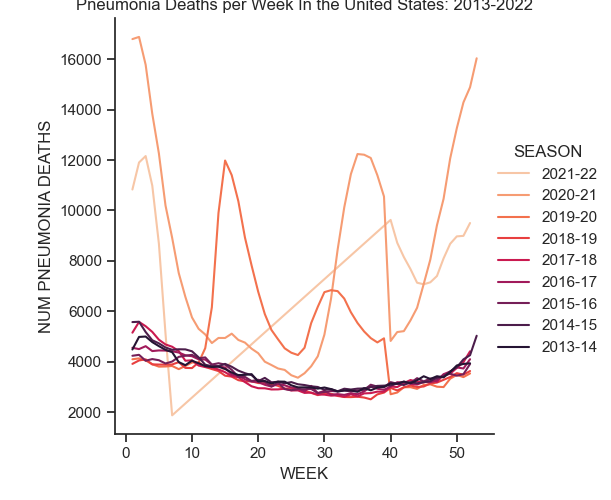

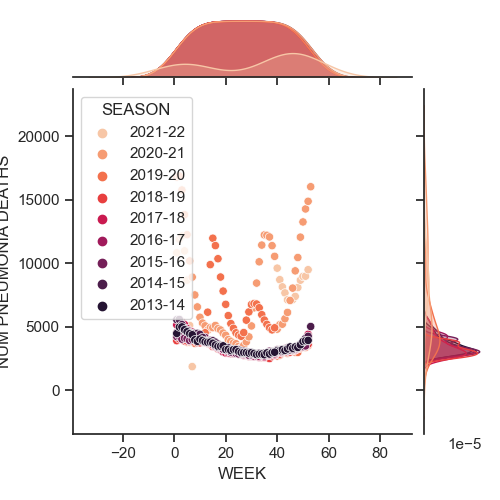

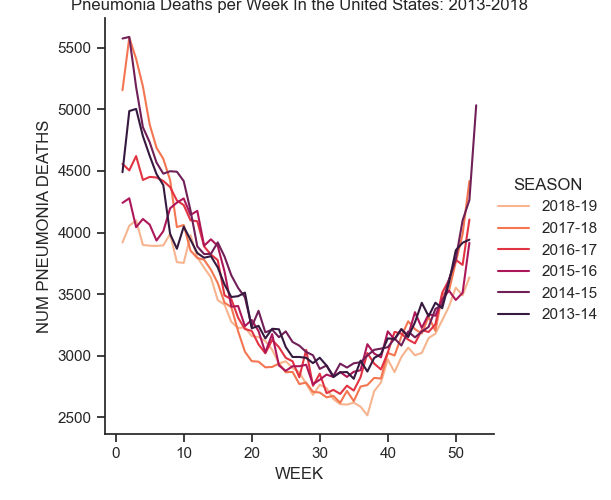

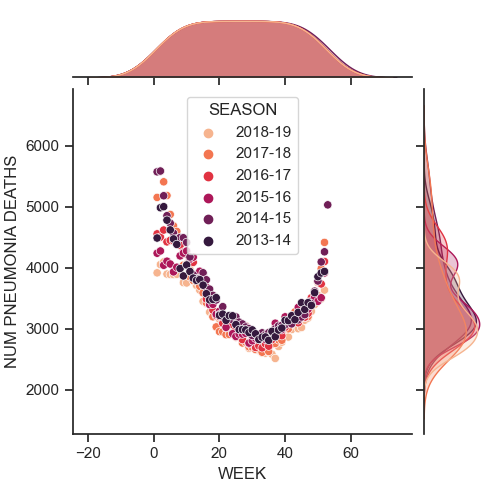

In [5]:
pnd = pnd.drop(pnd.columns[[0, 1, 7, 8, 9, 11, 12, 13, 14]], axis=1)
pnd.replace(",", "", regex=True, inplace=True)
pnd["NUM PNEUMONIA DEATHS"] = pd.to_numeric(
    pnd["NUM PNEUMONIA DEATHS"], errors="coerce"
)

sns.set_theme(style="ticks")
sns.relplot(
    data=pnd,
    x="WEEK",
    y="NUM PNEUMONIA DEATHS",
    hue="SEASON",
    kind="line",
    palette="rocket_r",
    height=5,
    facet_kws=dict(sharex=False),
).set(title="Pneumonia Deaths per Week In the United States: 2013-2022")
sns.jointplot(
    data=pnd,
    x="WEEK",
    y="NUM PNEUMONIA DEATHS",
    hue="SEASON",
    kind="scatter",
    palette="rocket_r",
    height=5,
)

pnd.drop(pnd.index[pnd["SEASON"] == "2021-22"], inplace=True)
pnd.drop(pnd.index[pnd["SEASON"] == "2020-21"], inplace=True)
pnd.drop(pnd.index[pnd["SEASON"] == "2019-20"], inplace=True)

sns.relplot(
    data=pnd,
    x="WEEK",
    y="NUM PNEUMONIA DEATHS",
    hue="SEASON",
    kind="line",
    palette="rocket_r",
    height=5,
    facet_kws=dict(sharex=False),
).set(title="Pneumonia Deaths per Week In the United States: 2013-2018")
sns.jointplot(
    data=pnd,
    x="WEEK",
    y="NUM PNEUMONIA DEATHS",
    hue="SEASON",
    kind="scatter",
    palette="rocket_r",
    height=5,
)

## Prepare the Training Data
The Chest X-ray data we are using from Cell divides the data into train, val, and test files. There are only 16 files in the validation folder, and we would prefer to have a less extreme division between the training and the validation set. We will append the validation files and create a new split that resembes the standard 80:20 division instead.

In [5]:
filenames = tf.io.gfile.glob(str(GCS_PATH + "chest_xray/train/*/*"))
filenames.extend(tf.io.gfile.glob(str(GCS_PATH + "chest_xray/val/*/*")))
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

### Set some constants
- AUTOTUNE: Sets the maximum parallel calls we can do based on our strategy.
- BATCH_SIZE: Size of each batch. Further multiplied by optimizer. Set this to the largest size that fits into your gpu mem. 
- IMG_SIZE: size of each image (max 600px, needs to be a square of 2). Set to 224 as its a good balance between speed, memory usage, and accuracy. 
- EPOCHS: Number of epochs to run. 2/3's of epoch's are used for initial training, and 1/3 are used for fine-tuning. I recommend setting this to a multiple of 15.

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMG_SIZE = 224
EPOCHS = 30

### Helper Functions
Currently our dataset is just a list of filenames. We want to map each filename to the corresponding `(image, label)` pair. The following methods will help us do that. As we only have two labels, we will rewrite the label so that `1` or `True` indicates pneumonia and `0` or `False` indicates normal. The images originally have values that range from `[0, 255]`. CNNs work better with smaller numbers so we will scale this down.

In [7]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"


def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_SIZE, IMG_SIZE])


def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

### Caching
Here we have a function to use buffered prefetching so we can yield data from disk without having I/O blocking while training the dataset. This especially helps with the TPU, although it increase time for the first epoch a fair bit.

Use buffered prefetching so we can yield data from disk without having I/O blocking

In [8]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

### Correct for Data Imbalence
There are way more images that are classified as pneumonia than normal. This shows that we have a imbalance in our data. The weight for class `0` (Normal) is a lot higher than the weight for class `1` (Pneumonia). Because there are less normal images, each normal image will be weighted more to balance the data, to optimize our CNN network and provide us with more accurate metrics.

In [9]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
COUNT_PNEUMONIA = len(
    [filename for filename in train_filenames if "PNEUMONIA" in filename]
)
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(
    tf.data.Dataset.from_tensor_slices(train_filenames)
).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(
    tf.data.Dataset.from_tensor_slices(val_filenames)
).numpy()
CLASS_NAMES = np.array(
    [
        str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
        for item in tf.io.gfile.glob(str(GCS_PATH + "/chest_xray/train/*"))
    ]
)

In [10]:
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0
class_weight = {0: weight_for_0, 1: weight_for_1}

### Load and Visualize Dataset
Now we can load the dataset. We use the `ts.data` api once again to prevent blocking and keep the GPU active. While we're at it, lets visualize some images.

2022-03-03 19:33:36.099984: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-03 19:33:38.655273: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


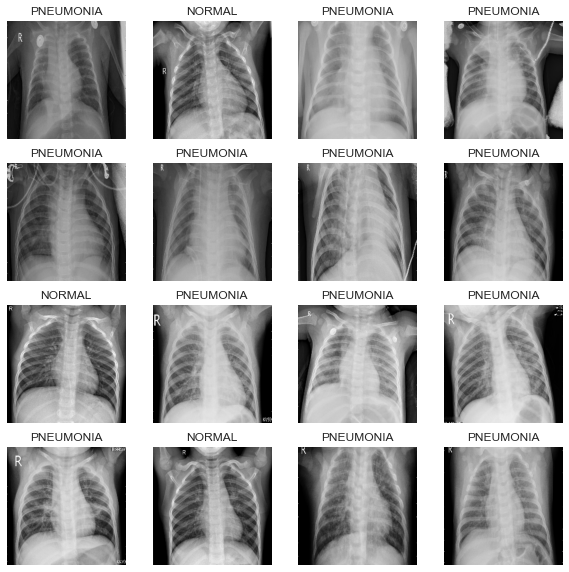

In [11]:
test_ds = (
    tf.data.Dataset.list_files(str(GCS_PATH + "chest_xray/test/*/*"))
    .map(process_path, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
)

train_ds = prepare_for_training(
    tf.data.Dataset.from_tensor_slices(train_filenames).map(
        process_path, num_parallel_calls=AUTOTUNE
    )
)
val_ds = prepare_for_training(
    tf.data.Dataset.from_tensor_slices(val_filenames).map(
        process_path, num_parallel_calls=AUTOTUNE
    )
)

image_batch, label_batch = next(iter(train_ds))


def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(16):
        ax = plt.subplot(4, 4, n + 1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


show_batch(image_batch.numpy(), label_batch.numpy())

## Train the model 
Our goal is to create a model that's capable of transfer learning on just the last fully-connected layer. 

We start with MobileNet V2 from Keras as the base model, which is pre-trained with the ImageNet dataset (trained to recognize 1,000 classes), providing us a great feature extractor for image classification. We then train a new classification layer with our pneumonia dataset. 

Why did we pick the MobileNet V2 model? Of all the pretrained models available on `tf.keras.applications` (MobileNet, DenseNet, Inception, Xception, NASNet, ResNet, and VGG) only 3 don't fill up the Edge TPU memory (MobileNet, Xception,and NASNet). Of those three MobileNet is the quickest to train, fastest to run, and 100% of its operations run on the Edge TPU. For comparison, only 11 of Xception's 128 operations, and only 1 of NASNetMobile's 991 operations run on the Edge TPU.

When instantiating the `MobileNetV2` model, we specify the `include_top=False` argument in order to load the network *without* the classification layers at the top. Then we set `trainable` false to freeze all the weights in the base model. This effectively converts the model into a feature extractor because all the pre-trained weights and biases are preserved in the lower layers when we begin training for our classification head.

We then create a new sequential model and pass the frozen MobileNet model as the base of the graph, and append new classification layers so we can set the final output dimension to match the number of classes in our dataset.

Afterwards, `compile()` the model (this is really just a configuration step). 

Since there are only two possible labels for the image, we will be using the` binary_crossentropy` loss. When we fit the model, identify the class weights. Because we are using a TPU and a small model combined with transfer learning, training will be relatively quick.

In [12]:
with strategy.scope():
    base_model = tf.keras.applications.MobileNetV2(
        weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False
    )
    base_model.trainable = False
    model = tf.keras.Sequential(
        [
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1),
        ]
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

### Tensorboard
TensorBoard provides the visualization and tooling needed for machine learning experimentation. It graphs and analyzes metrics, as well as optionally profiles our models.

In [13]:
%load_ext tensorboard
!rm -rf ./logs/
logdir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

### Initial Fitting
Pretty simple. Load our training dataset, set `epochs` to 2/3's of whats defined, set the weight to compensate for our imbalance of data, and add a `tensorboard_callback` so we can continously update tensorboard with our results.  

In [14]:
%%time
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=int((EPOCHS / 3) * 2),
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[tensorboard_callback],
)

Epoch 1/20
261/261 [==============================] - 46s 163ms/step - loss: 2.9676 - accuracy: 0.6746 - val_loss: 1.2664 - val_accuracy: 0.7548
Epoch 2/20
261/261 [==============================] - 31s 118ms/step - loss: 2.7721 - accuracy: 0.7359 - val_loss: 1.0118 - val_accuracy: 0.8250
Epoch 3/20
261/261 [==============================] - 30s 117ms/step - loss: 2.9726 - accuracy: 0.5771 - val_loss: 2.9957 - val_accuracy: 0.6048
Epoch 4/20
261/261 [==============================] - 34s 129ms/step - loss: 2.2819 - accuracy: 0.6477 - val_loss: 1.5800 - val_accuracy: 0.7442
Epoch 5/20
261/261 [==============================] - 33s 126ms/step - loss: 1.9231 - accuracy: 0.7423 - val_loss: 1.5125 - val_accuracy: 0.7721
Epoch 6/20
261/261 [==============================] - 32s 123ms/step - loss: 1.6532 - accuracy: 0.7371 - val_loss: 3.1241 - val_accuracy: 0.6019
Epoch 7/20
261/261 [==============================] - 32s 123ms/step - loss: 3.2214 - accuracy: 0.5424 - val_loss: 3.1750 - val_ac

### Finetune the model
Finetuning is an art when it comes to Machine Learning, and there are many ways to adjust the model in efforts to improve it. We unlock the last 100 layers of our `MobileNetV2` model, reduce the learning rate a bit, and give it 1/3's of the epochs defined above. We also need to recompile the model in order to save our changes.


In [15]:
%%time
with strategy.scope():
    base_model.trainable = True
    fine_tune_at = 100
    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

history_fine = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    initial_epoch=history.epoch[-1],
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[tensorboard_callback],
)

Epoch 20/30
261/261 [==============================] - 54s 204ms/step - loss: 1.6469 - accuracy: 0.8391 - val_loss: 0.5535 - val_accuracy: 0.9279
Epoch 21/30
261/261 [==============================] - 51s 197ms/step - loss: 0.7148 - accuracy: 0.8946 - val_loss: 0.4505 - val_accuracy: 0.9490
Epoch 22/30
261/261 [==============================] - 50s 192ms/step - loss: 0.5919 - accuracy: 0.9167 - val_loss: 0.4048 - val_accuracy: 0.9558
Epoch 23/30
261/261 [==============================] - 51s 197ms/step - loss: 0.5850 - accuracy: 0.9095 - val_loss: 0.4500 - val_accuracy: 0.9481
Epoch 24/30
261/261 [==============================] - 54s 206ms/step - loss: 0.6016 - accuracy: 0.9057 - val_loss: 0.4126 - val_accuracy: 0.9490
Epoch 25/30
261/261 [==============================] - 50s 193ms/step - loss: 0.5596 - accuracy: 0.9250 - val_loss: 0.2788 - val_accuracy: 0.9548
Epoch 26/30
261/261 [==============================] - 53s 203ms/step - loss: 0.4510 - accuracy: 0.9370 - val_loss: 0.2793 -

Now lets load tensorboard to show the results we saw earlier

In [16]:
%tensorboard --logdir logs

## Compiling for the Edge TPU 
The Google Edge TPU is an emerging hardware accelerator that is cost, power and speed efficient, and is available for prototyping and production purposes. The Edge TPU is not only capable of tackling common computer vision tasks, but also surpasses other hardware accelerators, especially when the entire model can be deployed to the Edge TPU. Co-embedding the Edge TPU in cameras allows a seamless analysis of primary data. In summary, the Edge TPU is a maturing system that has proven its usability across multiple tasks.

As stated earlier in the notebook, you need to quantize and optimize your model before deploying it to the Edge TPU. The quantized models use lower-precision (e.g. 8-bit instead of 32-bit float), leading to benefits during deployment, such as model compression, latency reduction, and compatibility with machine learning accelerators. Non-quantized models will run entirely on the CPU. As stated earlier in the notebook, the MobleNetV2 model has full compatiblity with the Edge TPU, as it can fit the compressed into its cache as well as run all its layers on the TPU accelerator. 

### Compile the Model for TFLite
There are several post-training quantization options to choose from, but we want to use full integer quantization, which provides a 4x reduction in size, and over a 3x speedup, and is the only model compatible with the Edge TPU and Microcontrollers. 

For full integer quantization, you need to calibrate or estimate the range, i.e, `(min, max)` of all floating-point tensors in the model. Unlike constant tensors such as weights and biases, variable tensors such as model input, activations (outputs of intermediate layers) and model output cannot be calibrated unless we run a few inference cycles. As a result, the converter requires a representative dataset to calibrate them. This dataset can be a small subset (around ~100-500 samples) of the training or validation data. We grab, decode, and resize 100 images using the `representative_dataset()` function below.

In [17]:
def representative_data_gen():
    dataset_list = tf.data.Dataset.list_files(GCS_PATH + "chest_xray/train/*/*")
    for i in range(100):
        path = next(iter(dataset_list))
        file_bytes = tf.io.read_file(path)
        img = tf.io.decode_jpeg(file_bytes, channels=3)
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
        img = tf.expand_dims(img, 0)
        yield [img]

In [18]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model_quant = converter.convert()

2022-03-03 19:54:13.628657: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /var/folders/vf/7353c1ls6wzg4gqk6f49zjn00000gn/T/tmpxxymj9bk/assets


INFO:tensorflow:Assets written to: /var/folders/vf/7353c1ls6wzg4gqk6f49zjn00000gn/T/tmpxxymj9bk/assets
/Users/shauryasingh/miniforge3/envs/edgetpu/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-03-03 19:54:49.912190: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-03-03 19:54:49.912224: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-03-03 19:54:49.913424: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/vf/7353c1ls6wzg4gqk6f49zjn00000gn/T/tmpxxymj9bk
2022-03-03 19:54:49.929383: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-03-03 19:54:49.929399: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel d

Now that we compiled it, lets quickly check out inputs and ouputs are indeed `uint8`

In [19]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]["dtype"]
output_type = interpreter.get_output_details()[0]["dtype"]
print("input: ", input_type)
print("output: ", output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


### Writing the required files
The `classify_image.py` file we have setup to build and our model requires some labels. Lets download the model file and write the labels to a `.txt` file while we're at it.

In [20]:
with open("xray_mobilenetv2_quant_model.tflite", "wb") as f:
    f.write(tflite_model_quant)

np.savetxt("xray_labels.txt", CLASS_NAMES)

### Compiling for Edge TPU
Google's edgeTPU compiler only works on linux, and only on x86_64 at that. Lets spin up a docker container to get that working run `docker build --platform linux/amd64 --tag edgetpu_compiler https://github.com/tomassams/docker-edgetpu-compiler.git` if you haven't already, as it builds the container. Obvioiusly make sure you have Docker installed as well. 

The following cell will compile and write our model to `xray_mobilenetv2_quant_model_edgetpu.tflite`

In [21]:
!docker run -it --platform linux/amd64 --rm -v (pwd):/home/edgetpu edgetpu_compiler edgetpu_compiler --min_runtime_version 13 xray_mobilenetv2_quant_model.tflite

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 7289 ms.

Input model: xray_mobilenetv2_quant_model.tflite
Input size: 2.59MiB
Output model: xray_mobilenetv2_quant_model_edgetpu.tflite
Output size: 2.79MiB
On-chip memory used for caching model parameters: 2.71MiB
On-chip memory remaining for caching model parameters: 4.99MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 70
Operation log: xray_mobilenetv2_quant_model_edgetpu.log
See the operation log file for individual operation details.
Compilation child process completed within timeout period.
Compilation succeeded! 


Lets just double check everything is mapped to the TPU:

In [22]:
!cat xray_mobilenetv2_quant_model_edgetpu.log

Edge TPU Compiler version 16.0.384591198
Input: xray_mobilenetv2_quant_model.tflite
Output: xray_mobilenetv2_quant_model_edgetpu.tflite

Operator                       Count      Status

ADD                            10         Mapped to Edge TPU
FULLY_CONNECTED                1          Mapped to Edge TPU
PAD                            4          Mapped to Edge TPU
DEPTHWISE_CONV_2D              17         Mapped to Edge TPU
CONV_2D                        35         Mapped to Edge TPU
QUANTIZE                       2          Mapped to Edge TPU
MEAN                           1          Mapped to Edge TPU


## Final Steps
Looks like everything is compatible! Now we can run our model on the devboard using the following command:
```sh
python3 classify_image.py \
  --model xray_mobilenetv2_quant_model_edgetpu.tflite  \
  --labels xray_labels.txt \
  --input chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
```

Here's my results, your's might be slightly faster or slower:
```
mendel@green-bunny:~/xray-pneumonia-transfer-learning-edge-tpu$ python3 classify_image.py \
>   --model xray_mobilenetv2_quant_model_edgetpu.tflite  \
>   --labels xray_labels.txt \
>   --input chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
----INFERENCE TIME----
Note: The first inference on Edge TPU is slow because it includes loading the model into Edge TPU memory.
115.7ms
14.6ms
14.6ms
14.5ms
14.4ms
-------RESULTS--------
PNEUMONIA: 7.16323
```